sseeds 3.27.23 - Script adapted from existing scripts to test Jupyter Notebooks on farm and functionality.

# Get Beam Energy
**This script will get the average beam energy per run over SBS GMn configurations.**


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Reading config file
conf_file = open('sgetcharge.json')
conf = json.load(conf_file)
print("Config file for SBS-{}, {} data has been loaded..".format(conf['SBS_config'], conf['target']))

Config file for SBS-9, LH2 data has been loaded..


In [4]:
# Reading CSV file generated from get_avgHALLA_p_prun.cpp script. It should contain HALLA_p values and global event numbers per run
ebeamdf = pd.DataFrame(pd.read_csv("epics_out/be_sbs{}_{}.csv".format(conf['SBS_config'], conf['target'])))
ebeamdf['HALLA_p_gev'] = ebeamdf['HALLA_p'] / 1000.0  # let's add a column for ebeam value in GeV
ebeamdf.head()

,runnum,evnum,HALLA_p,HALLA_p_gev
0,13656,46675,4014.83,4.01483
1,13656,67742,4014.81,4.01481
2,13656,88778,4014.81,4.01481
3,13656,109926,4014.83,4.01483
4,13656,130899,4014.83,4.01483


In [6]:
# Calculating mean and std of beam energy per run
avgebeamdf = ebeamdf.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
avgebeamdf.head()

runnum HALLA_p_gev          
                mean       std
0  13656    4.014812  0.000092
1  13657    4.014732  0.000139
2  13663    4.014777  0.000139
3  13676    4.014736  0.000064
4  13683    4.014730  0.000054

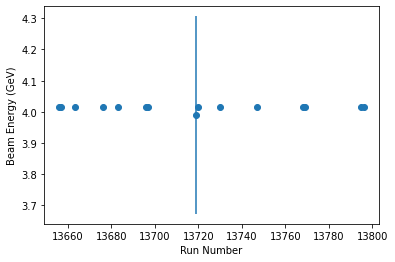

In [7]:
# Plotting average HALLA_p as a function of run numbers (std values are shown as yerrors)
cut_sigma = avgebeamdf['HALLA_p_gev']['std'] < 1 #0.0006 # Defining a cut definition to choose range of std
plt.errorbar(avgebeamdf['runnum'][cut_sigma], avgebeamdf['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf['HALLA_p_gev']['std'][cut_sigma], fmt='o')
#plt.xticks(avgebeamdf['runnum'], rotation=90)
#plt.xlim(12670,12700)
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

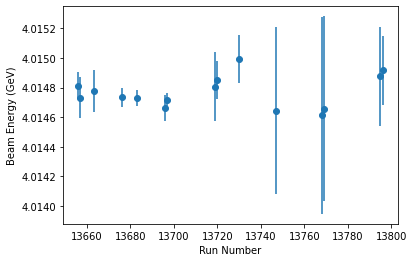

In [8]:
# 1. HALLA_p > 0
ebeamdf_nz = ebeamdf[ebeamdf['HALLA_p'] != 0] # applying the filter
# Calculating mean and std of beam energy per run again with filtered data
avgebeamdf_nz = ebeamdf_nz.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
# Plotting average HALLA_p as a function of run numbers (std values are shown as yerrors)
cut_sigma_nz = avgebeamdf_nz['HALLA_p_gev']['std'] < 1 #0.0006 # Defining a cut definition to choose range of std
plt.errorbar(avgebeamdf_nz['runnum'][cut_sigma], avgebeamdf_nz['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf_nz['HALLA_p_gev']['std'][cut_sigma], fmt='o')
#plt.xticks(avgebeamdf['runnum'], rotation=90)
#plt.xlim(12670,12700)
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

In [9]:
# 2. Unique EPICS event for a unique global event
ebeamdf_nz_nd = ebeamdf_nz.drop_duplicates(subset=['runnum', 'evnum'], keep='first')
ebeamdf_nz_nd.head()

,runnum,evnum,HALLA_p,HALLA_p_gev
0,13656,46675,4014.83,4.01483
1,13656,67742,4014.81,4.01481
2,13656,88778,4014.81,4.01481
3,13656,109926,4014.83,4.01483
4,13656,130899,4014.83,4.01483


In [10]:
# Calculating total no of EPICS events per run before and after filtering duplicate entries
# before
nevents_epics_bf = ebeamdf_nz['runnum'].value_counts().reset_index()
nevents_epics_bf_df = pd.DataFrame(nevents_epics_bf)
nevents_epics_bf_df.columns = ['runnum', 'nevents']
#nevents_epics.to_frame() # this is not working! No clue why!
# after
nevents_epics_af = ebeamdf_nz_nd['runnum'].value_counts().reset_index()
nevents_epics_af_df = pd.DataFrame(nevents_epics_af)
nevents_epics_af_df.columns = ['runnum', 'nevents']
# calculate difference for a particular run
#nevents_epics_bf_df[nevents_epics_bf_df['runnum'] == 12902] - nevents_epics_af_df[nevents_epics_af_df['runnum'] == 12902]

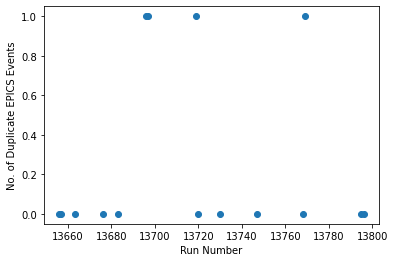

In [11]:
# Take difference in total number of EPICS events before and after and then plot the values vs run numbers
ndup_prun = pd.merge(nevents_epics_bf, nevents_epics_af, on='runnum', suffixes=('', '_ndup'))
ndup_prun['ndup'] = ndup_prun['nevents'] - ndup_prun['nevents_ndup']
plt.scatter(x=ndup_prun['runnum'], y=ndup_prun['ndup'])
plt.xlabel('Run Number')
plt.ylabel('No. of Duplicate EPICS Events')
plt.show()

In [12]:
# # Calculating final mean and std of beam energy per run with completely filtered data
avgebeamdf_nz_nd = ebeamdf_nz_nd.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
avgebeamdf_nz_nd.head()

runnum HALLA_p_gev          
                mean       std
0  13656    4.014812  0.000092
1  13657    4.014732  0.000139
2  13663    4.014777  0.000139
3  13676    4.014736  0.000064
4  13683    4.014730  0.000054

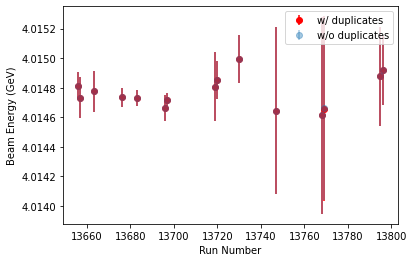

In [13]:
# Plotting HALLA_p as a function of run numbers w/ and w/o cuts on duplicate EPICS events
cut_sigma = avgebeamdf_nz['HALLA_p_gev']['std'] < 1
cut_sigma_nd = avgebeamdf_nz_nd['HALLA_p_gev']['std'] < 1
plt.errorbar(avgebeamdf_nz['runnum'][cut_sigma], avgebeamdf_nz['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf_nz['HALLA_p_gev']['std'][cut_sigma], fmt='o', color='r', label='w/ duplicates')
plt.errorbar(avgebeamdf_nz_nd['runnum'][cut_sigma], avgebeamdf_nz_nd['HALLA_p_gev']['mean'][cut_sigma_nd], yerr=avgebeamdf_nz_nd['HALLA_p_gev']['std'][cut_sigma_nd], fmt='o', alpha=0.4, label='w/o duplicates')
#plt.xticks(sbs11_ld2_mean_std_p_run_nz_nd['runnum'], rotation=90)
#plt.xlim(12650,12700)
plt.legend()
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

In [14]:
# Getting tables with HALLA_p_mean and HALLA_p_std per run and saving the values in a CSV file
trun_nz_nd = avgebeamdf_nz_nd['runnum']
tmean_nz_nd = avgebeamdf_nz_nd['HALLA_p_gev']['mean']
tstd_nz_nd = avgebeamdf_nz_nd['HALLA_p_gev']['std']
tm1_nz_nd = pd.merge(trun_nz_nd, tmean_nz_nd, left_index=True, right_index=True)
final_table_nz_nd = pd.merge(tm1_nz_nd, tstd_nz_nd, left_index=True, right_index=True)
final_table_nz_nd.columns = ['runnum', 'ebeam_mean(GeV)', 'ebeam_std(GeV)']
final_table_nz_nd.head()

,runnum,ebeam_mean(GeV),ebeam_std(GeV)
0,13656,4.014812,0.000092
1,13657,4.014732,0.000139
2,13663,4.014777,0.000139
3,13676,4.014736,0.000064
4,13683,4.014730,0.000054


In [15]:
anyNaN = final_table_nz_nd.isnull().values.any()
#final_table_nz_nd.loc[pd.isna(final_table_nz_nd).any(1), :].index
if (anyNaN == True): 
    print('NaN exists! Replacing with 0')
    final_table_nz_nd = final_table_nz_nd.fillna(0)

In [16]:
# write out a csv file
#outfile = '../../DB/{}/avg_ebeam_prun_sbs{}_{}.csv'.format(conf['target'], conf['SBS_config'], conf['target'])
#final_table_nz_nd.to_csv(outfile, index=False)
#print("Average beam energy per run for SBS-{}, {} data has been written to {}.".format(conf['SBS_config'], conf['target'], outfile))

In [17]:
#final_table_nz_nd['ebeam_std(GeV)'].max() - final_table_nz['ebeam_std(GeV)'].max()
#final_table_nz_nd['ebeam_std(GeV)'][final_table_nz_nd['runnum'] != 12902].max()
np.round(final_table_nz_nd['ebeam_mean(GeV)'].mean() * 1.003, 4)

4.0268

In [18]:
final_table_nz_nd['ebeam_std(GeV)'].max() * 1.003

0.0006685706496136159

In [19]:
import seaborn as sns

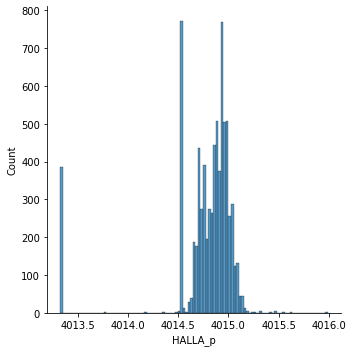

In [20]:
# All runs
sns.displot(data=ebeamdf_nz_nd, x='HALLA_p')

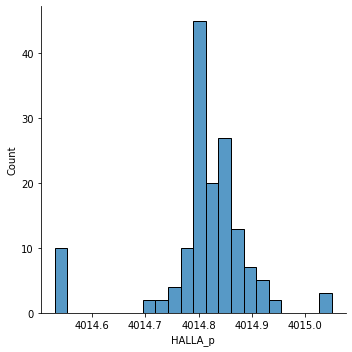

In [21]:
# For a single run of choice
run = ebeamdf_nz_nd['runnum'][0]
sns.displot(data=ebeamdf_nz_nd[ebeamdf_nz_nd['runnum'] == run], x='HALLA_p')

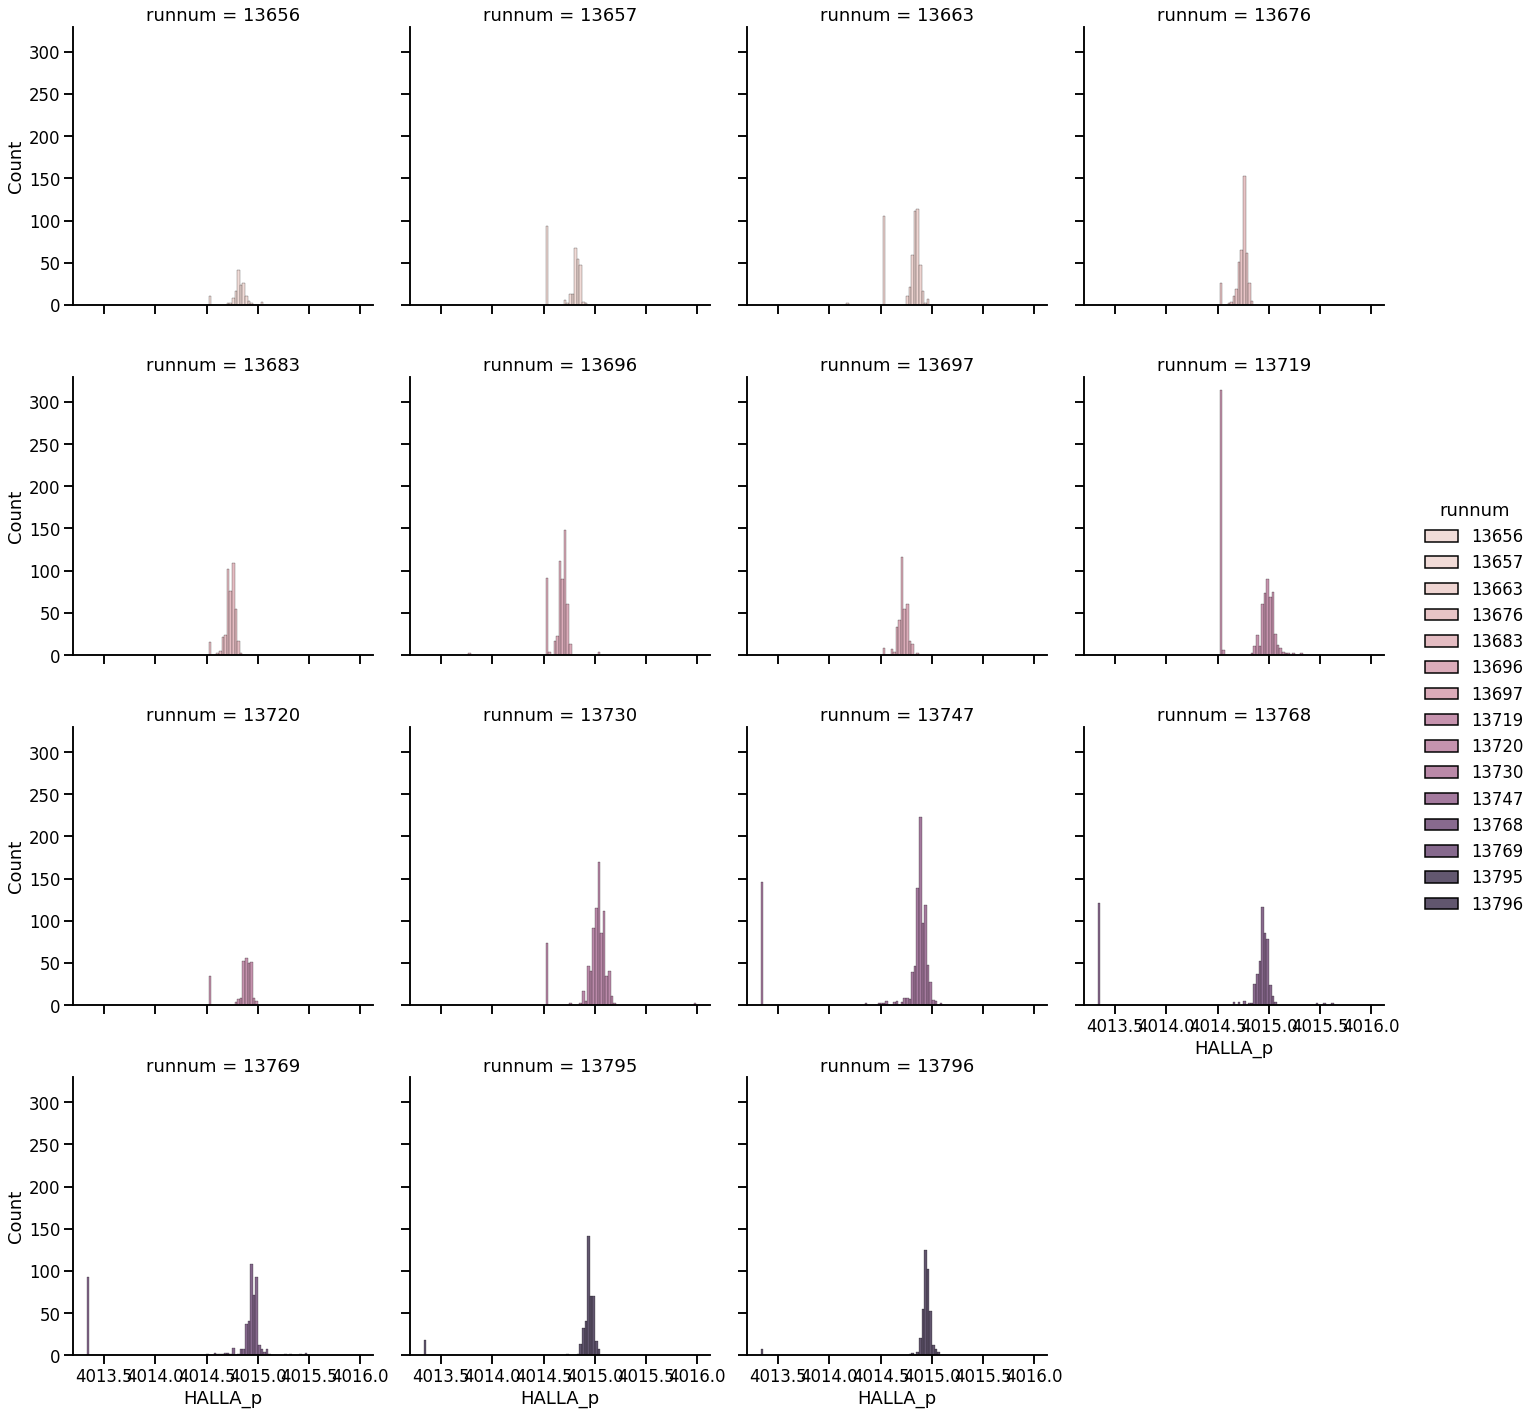

In [22]:
# For all runs at once!
sns.set_context('talk')
sns.displot(data=ebeamdf_nz_nd, x='HALLA_p', hue='runnum', col='runnum', col_wrap=4)